# Transfer Learning

A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

Convolution > Pool > Convolution > Pool > Flatten | > Fully-Connected 

             Feature Extraction                       |   Classification

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using Tensorflow.

## Import libraries

First, let's import the Tensorflow libraries we're going to use.

In [1]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.3.0
Keras version: 2.4.0


### Preparing the Data
Before we can train the model, we need to prepare the data.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
# Our source images are 128x128, but the base model we're going to use was trained with 224x224 images
pretrained_size = (224,224)
batch_size = 15

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
class names:  ['circle', 'square', 'triangle']


### Downloading a trained model to use as a base

The ***resnet*** model is an CNN-based image classifier that has been pre-trained using a huge dataset containing thousands of images of many kinds of object. We'll download the trained model, excluding its final linear layer, and freeze the feature extraction layers to retain the trained weights. Then we'll create a fully-connected layer that takes the features extracted by the convolutional layers as an input and generates a prediction probability output for each of our possible classes.

In [3]:
from tensorflow.keras import applications
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense

#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = keras.applications.resnet.ResNet50(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]         

### Training the Model
With the layers of the CNN defined, we're ready to train the top layer using our image data.

In [4]:
# Train the model over 5 epochs
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
56/56 [==============================] - 50s 886ms/step - loss: 1.4828 - accuracy: 0.6774 - val_loss: 0.1397 - val_accuracy: 0.9806
Epoch 2/5
56/56 [==============================] - 47s 847ms/step - loss: 0.2025 - accuracy: 0.9298 - val_loss: 0.5572 - val_accuracy: 0.8167
Epoch 3/5
56/56 [==============================] - 47s 846ms/step - loss: 0.1714 - accuracy: 0.9381 - val_loss: 0.0617 - val_accuracy: 0.9972
Epoch 4/5
56/56 [==============================] - 48s 850ms/step - loss: 0.1102 - accuracy: 0.9607 - val_loss: 0.1503 - val_accuracy: 0.9361
Epoch 5/5
56/56 [==============================] - 47s 843ms/step - loss: 0.0696 - accuracy: 0.9810 - val_loss: 0.0381 - val_accuracy: 1.0000


### View the Loss History

We tracked average training and validation loss for each epoch. We can plot these to verify that the loss reduced over the training process and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

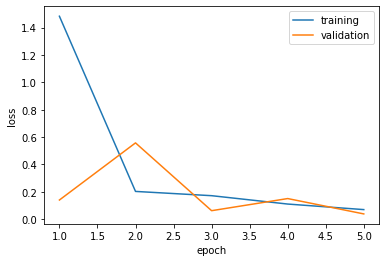

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Evaluate Model Performance
We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Generating predictions from validation data...


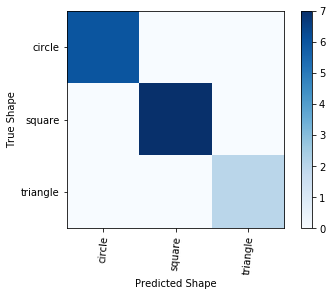

In [6]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the moedl to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

### Using the Trained Model
Now that we've trained the model, we can use it to predict the class of an image.

triangle


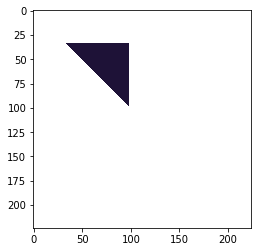

In [7]:
from random import randint
from PIL import Image
import numpy as np

def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
img = create_image ((224,224), classnames[randint(0, len(classnames)-1)])
plt.imshow(img)

# Modify the image data to match the format of the training features
img = np.array(Image.fromarray(img))
imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
imgfeatures = imgfeatures.astype('float32')
imgfeatures /= 255

# Use the classifier to predict the class
predicted_class = model.predict(imgfeatures)
# Find the class with the highest predicted probability
i = np.where(predicted_class == predicted_class.max())
print (classnames[int(i[1])])

## Learning More

* [Tensorflow Documentation](https://www.tensorflow.org/tutorials/images/transfer_learning)